In [3]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("/Users/kai/Downloads/graduation/AMFtrack")
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import json
import imageio
import logging
import cv2
from skimage.measure import profile_line
from amftrack.pipeline.functions.image_processing.experiment_class_surf import *
from amftrack.pipeline.functions.image_processing.experiment_util import *
from amftrack.util.sys import *
from amftrack.util.plot import *
from amftrack.util.geometry import *
from amftrack.util.image_analysis import *
from amftrack.pipeline.functions.image_processing.extract_width_fun import *
sys.path.append("/Users/kai/Downloads/graduation/CNN_model/Graduation-Project")
from models.config import *
from models.video import *
from models.model import *
from multiprocessing import Process,Manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
directory = "/Users/kai/Downloads/"
update_plate_info(directory)
folder_df = get_current_folders(directory)
file_names = folder_df.folder.tolist()
file_names

analysed:   0%|          | 0/259 [00:00<?, ?it/s]

['20220516_1611_Plate02',
 '20230111_1349_Plate02',
 '20220515_0949_Plate02',
 '20220621_0916_Plate25',
 '20230113_0949_Plate02',
 '20220516_2211_Plate02',
 '20220512_0304_Plate02',
 '20230109_1409_Plate02']

In [4]:
model_path ="/Users/kai/Downloads/graduation/CNN_model/Graduation-Project/models/"
f_profiles = lambda edge: extract_section_profiles_for_edge(
        exp, 0, edge, resolution=5, offset=5, step=1,target_length=120)
model = load_model(model_path,"BO_without_crop_best_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [11]:
def get_all_edges_by_degree(exp,t=0,degree=3):
    from amftrack.pipeline.functions.image_processing.experiment_util import get_all_nodes
    import networkx as nx
    node_list = get_all_nodes(exp, t)
    G, pos = exp.nx_graph[t], exp.positions[t]
    collect = []
    for i in node_list:
        if i.degree(t) == degree:
            collect.append(int(str(i)))
    return [G.edges(i) for i in collect]

def get_main_side_width(exp,t,model,edge_list):
    edge = [get_edge_from_node_labels(exp,t,node1,node2) for node1,node2 in edge_list]
    slices = [f_profiles(edge_)[0] for edge_ in edge ]
    width = [np.median(model.predict(slice_,verbose=0)) for slice_ in slices]
    width.sort(reverse=True)
    return edge, slices, np.array(width) 

def get_main_side_width_new(exp,t,model,edge_list):
    edges = [get_edge_from_node_labels(exp,t,node1,node2) for node1,node2 in edge_list]
    slices = []
    correct_edge = []
    for edge in edges:
        if len(edge.pixel_list(0)) > 100:
            slices.append(f_profiles(edge)[0])
            correct_edge.append(edge)
    width = [np.median(model.predict(slice_,verbose=0)) for slice_ in slices]
    width.sort(reverse=True)
    return correct_edge, slices, np.array(width) 

In [5]:
folder = folder_df[folder_df.folder == file_names[0]]
exp = Experiment(directory)
exp.load(folder)

/Users/kai/Downloads/graduation/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2022-05-12 03:04:00


In [6]:
edge_list = get_all_edges_by_degree(exp,0,degree=3)

NameError: name 'get_all_edges_by_degree' is not defined

## Plate 05150949

In [61]:
# t= 0
# edge_list = get_all_edges_by_degree(exp,t,degree=3)
width_result = []
edge_result = []
for edges in edge_list:
    print(edges)
    collect_width = []
    collect_edge = []
    for node1,node2 in edges:
        edge = get_edge_from_node_labels(exp,t,node1,node2)
        if edge.width(0) != 0:
            collect_width.append(edge.width(0))
            collect_edge.append(edge)
    if len(collect_width) == 3:
        width_result.append(collect_width)
        edge_result.append(collect_edge)

[(15102, 258518), (15102, 15100), (15102, 262376)]
[(15092, 262370), (15092, 15093), (15092, 15095)]
[(263358, 263360), (263358, 265286), (263358, 262379)]
[(15093, 15092), (15093, 15095), (15093, 15094)]
[(15095, 15092), (15095, 15093), (15095, 15097)]
[(15097, 15095), (15097, 15098), (15097, 15094)]
[(15094, 15093), (15094, 15097), (15094, 15096)]
[(15098, 15097), (15098, 15096), (15098, 8020)]
[(15096, 15094), (15096, 15098), (15096, 8020)]
[(15088, 8020), (15088, 15087), (15088, 15090)]
[(266067, 8020), (266067, 15100), (266067, 263668)]
[(15100, 15102), (15100, 266067), (15100, 262376)]
[(263668, 266067), (263668, 15090), (263668, 263332)]
[(262376, 15102), (262376, 15100), (262376, 261671)]
[(15087, 15088), (15087, 13834), (15087, 15089)]
[(15090, 15088), (15090, 263668), (15090, 15089)]
[(13834, 15087), (13834, 15082), (13834, 14445)]
[(15089, 15087), (15089, 15090), (15089, 14445)]
[(15082, 13834), (15082, 15080), (15082, 15085)]
[(14445, 13834), (14445, 15089), (14445, 15085)]

In [62]:
mh,dh1,dh2 =[],[],[]
for i in width_result:
    i.sort()
    mh.append(i[2])
    dh1.append(i[1])
    dh2.append(i[0])

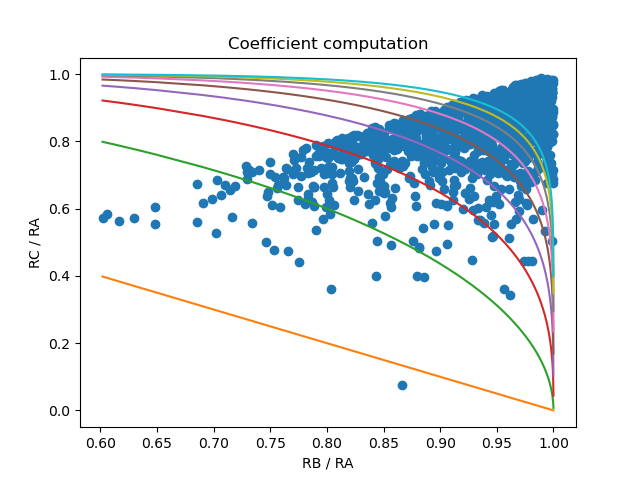

In [69]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
x = dh1/mh
y = dh2/mh
plt.plot(x,y,"o")
plt.xlabel("RB / RA")
plt.ylabel("RC / RA")
x.sort()
for i in range(1,10):
    plt.plot(x,(1-x**i)**(1/i),label=f'power {i}')
plt.title("Coefficient computation")
plt.show()

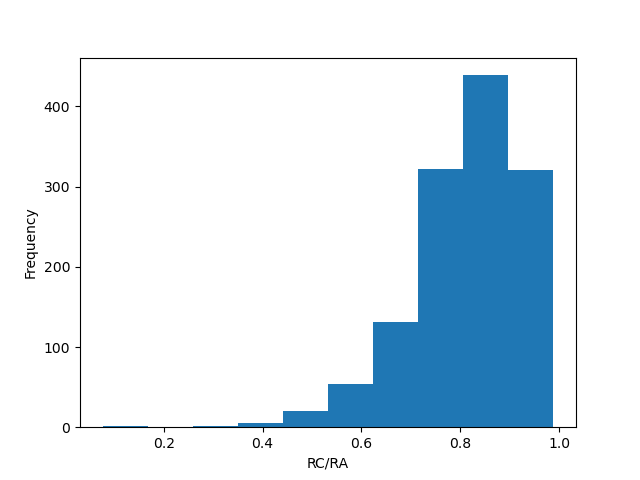

In [70]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
plt.hist(dh2/mh,bins=10)
plt.xlabel("RC/RA")
plt.ylabel("Frequency")
plt.show()

In [71]:
ratio = dh2/mh

In [72]:
np.where(ratio<0.7)

(array([   1,    2,    3,   12,   15,   36,   42,   51,   84,   87,  109,
         110,  112,  138,  144,  150,  154,  158,  169,  227,  229,  253,
         280,  289,  315,  321,  342,  354,  358,  366,  383,  400,  402,
         404,  419,  425,  428,  429,  433,  446,  448,  483,  484,  489,
         494,  497,  503,  508,  514,  515,  518,  531,  533,  535,  537,
         538,  539,  565,  568,  580,  585,  607,  618,  619,  633,  653,
         665,  675,  677,  686,  690,  699,  700,  706,  709,  711,  714,
         715,  717,  720,  734,  747,  749,  753,  764,  765,  769,  775,
         779,  780,  781,  782,  783,  795,  797,  803,  812,  815,  817,
         819,  822,  832,  841,  853,  856,  858,  888,  910,  916,  919,
         921,  927,  930,  932,  937,  953,  954,  961,  983, 1002, 1003,
        1012, 1033, 1034, 1036, 1037, 1042, 1043, 1044, 1051, 1052, 1053,
        1055, 1056, 1065, 1074, 1075, 1078, 1081, 1086, 1088, 1094, 1097,
        1098, 1100, 1101, 1103, 1116, 

In [73]:
edge_result[2]

[Edge(262376,261671), Edge(263332,261671), Edge(261671,262379)]

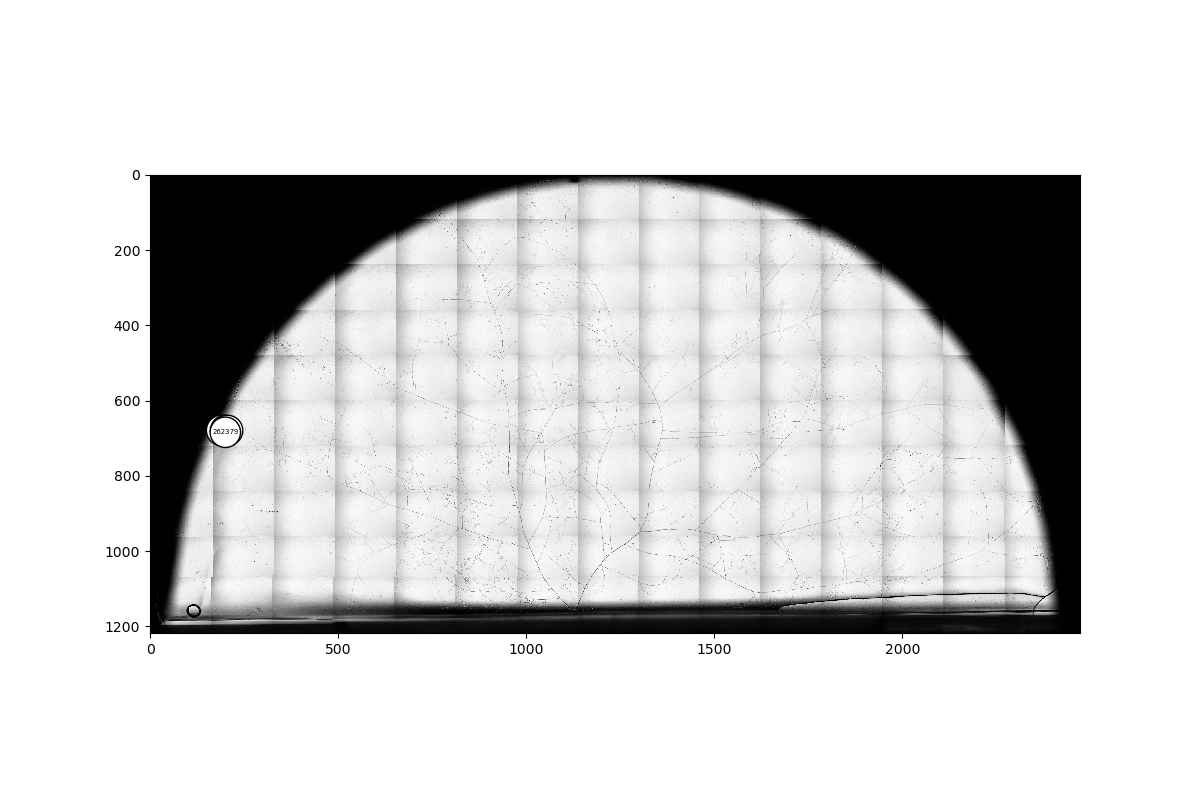

In [76]:
nodes = []
for path in [262376,261671, 263332,262379]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=20,
    nodes = node_list,
    save_path = "/home/ipausers/lin/Desktop/Kai/Graduation-Project/test.png"
)

In [77]:
np.where(ratio>0.8)

(array([   0,    4,    9,   10,   11,   14,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   31,   33,   34,
          37,   39,   40,   44,   45,   46,   47,   48,   49,   50,   52,
          53,   54,   56,   57,   58,   59,   60,   61,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   73,   74,   75,   77,   78,
          80,   81,   82,   85,   88,   89,   90,   93,   94,   96,   98,
          99,  100,  102,  104,  105,  106,  107,  111,  113,  115,  116,
         117,  118,  119,  121,  122,  123,  124,  125,  126,  127,  128,
         129,  130,  132,  134,  136,  137,  139,  140,  141,  143,  148,
         149,  155,  156,  157,  162,  163,  164,  165,  168,  172,  175,
         176,  177,  178,  179,  180,  181,  182,  183,  184,  185,  187,
         188,  189,  190,  191,  192,  193,  194,  196,  197,  198,  199,
         202,  203,  204,  205,  206,  208,  209,  211,  212,  213,  214,
         216,  217,  218,  219,  220, 

In [78]:
edge_result[0]

[Edge(263360,263358), Edge(263358,265286), Edge(263358,262379)]

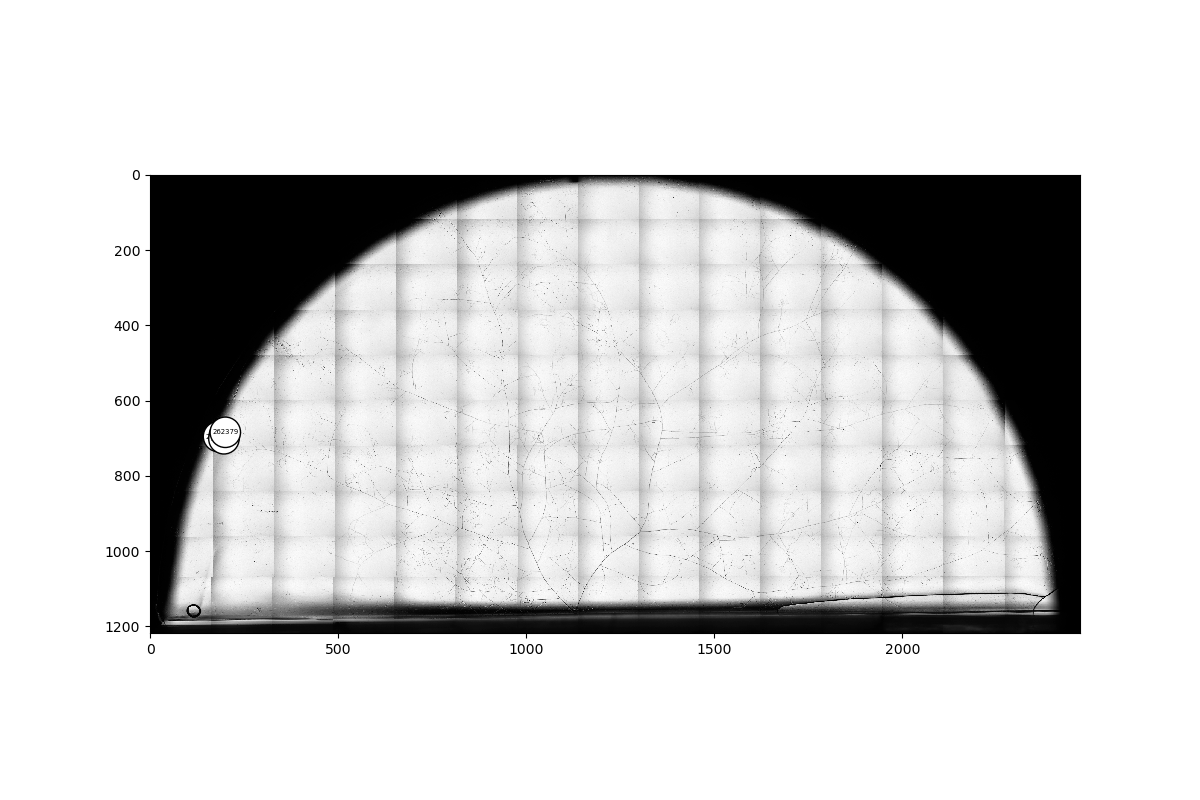

In [79]:
nodes = []
for path in [263360,263358, 265286,262379]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=20,
    nodes = nodes,
)

## Plate 05161611

In [82]:
folder = folder_df[folder_df.folder == file_names[1]]
exp = Experiment(directory)
exp.load(folder)

/Users/kai/Downloads/graduation/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2022-05-16 16:11:00


In [12]:
t= 0
edge_list = get_all_edges_by_degree(exp,t,degree=3)
width_result = []
edge_result = []
for edges in edge_list:
    print(edges)
    collect_width = []
    collect_edge = []
    for node1,node2 in edges:
        edge = get_edge_from_node_labels(exp,t,node1,node2)
        if edge.width(0) != 0:
            collect_width.append(edge.width(0))
            collect_edge.append(edge)
    if len(collect_width) == 3:
        width_result.append(collect_width)
        edge_result.append(collect_edge)

[(274817, 274816), (274817, 274815), (274817, 274818)]
[(274815, 274816), (274815, 274817), (274815, 274807)]
[(274807, 274815), (274807, 274818), (274807, 274813)]
[(260325, 274813), (260325, 273760), (260325, 274801)]
[(274814, 273791), (274814, 267327), (274814, 274801)]
[(267327, 273791), (267327, 274814), (267327, 270936)]
[(270936, 267327), (270936, 271484), (270936, 271491)]
[(273760, 260325), (273760, 274801), (273760, 274261)]
[(271484, 270936), (271484, 274801), (271484, 271491)]
[(271491, 270936), (271491, 271484), (271491, 272686)]
[(272686, 271491), (272686, 274284), (272686, 273761)]
[(274284, 272686), (274284, 273761), (274284, 269944)]
[(273761, 272686), (273761, 274284), (273761, 268942)]
[(268942, 273761), (268942, 269944), (268942, 269907)]
[(269944, 274284), (269944, 268942), (269944, 269517)]
[(269517, 269944), (269517, 269907), (269517, 270385)]
[(269907, 268942), (269907, 269517), (269907, 270385)]
[(262376, 258518), (262376, 266067), (262376, 261671)]
[(272661, 

In [13]:
mh,dh1,dh2 =[],[],[]
for i in width_result:
    i.sort()
    mh.append(i[2])
    dh1.append(i[1])
    dh2.append(i[0])

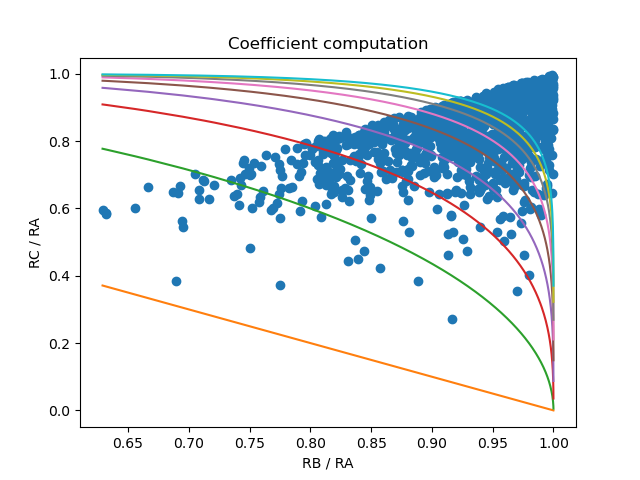

In [14]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
x = dh1/mh
y = dh2/mh
plt.plot(x,y,"o")
plt.xlabel("RB / RA")
plt.ylabel("RC / RA")
x.sort()
for i in range(1,10):
    plt.plot(x,(1-x**i)**(1/i),label=f'power {i}')
plt.title("Coefficient computation")
plt.show()

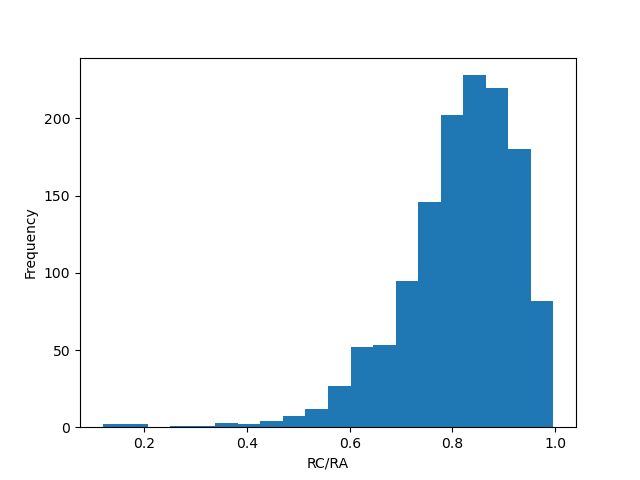

In [90]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
plt.hist(dh2/mh,bins=20)
plt.xlabel("RC/RA")
plt.ylabel("Frequency")
plt.show()

## Plate 05120304

In [15]:
folder = folder_df[folder_df.folder == file_names[0]]
exp = Experiment(directory)
exp.load(folder)

/Users/kai/Downloads/graduation/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2022-05-12 03:04:00


In [16]:
t= 0
edge_list = get_all_edges_by_degree(exp,t,degree=3)
width_result = []
edge_result = []
for edges in edge_list:
    print(edges)
    collect_width = []
    collect_edge = []
    for node1,node2 in edges:
        edge = get_edge_from_node_labels(exp,t,node1,node2)
        if edge.width(0) != 0:
            collect_width.append(edge.width(0))
            collect_edge.append(edge)
    if len(collect_width) == 3:
        width_result.append(collect_width)
        edge_result.append(collect_edge)

[(274817, 274816), (274817, 274815), (274817, 274818)]
[(274815, 274816), (274815, 274817), (274815, 274807)]
[(274807, 274815), (274807, 274818), (274807, 274813)]
[(260325, 274813), (260325, 273760), (260325, 274801)]
[(274814, 273791), (274814, 267327), (274814, 274801)]
[(267327, 273791), (267327, 274814), (267327, 270936)]
[(270936, 267327), (270936, 271484), (270936, 271491)]
[(273760, 260325), (273760, 274801), (273760, 274261)]
[(271484, 270936), (271484, 274801), (271484, 271491)]
[(271491, 270936), (271491, 271484), (271491, 272686)]
[(272686, 271491), (272686, 274284), (272686, 273761)]
[(274284, 272686), (274284, 273761), (274284, 269944)]
[(273761, 272686), (273761, 274284), (273761, 268942)]
[(268942, 273761), (268942, 269944), (268942, 269907)]
[(269944, 274284), (269944, 268942), (269944, 269517)]
[(269517, 269944), (269517, 269907), (269517, 270385)]
[(269907, 268942), (269907, 269517), (269907, 270385)]
[(262376, 258518), (262376, 266067), (262376, 261671)]
[(272661, 

In [17]:
mh,dh1,dh2 =[],[],[]
for i in width_result:
    i.sort()
    mh.append(i[2])
    dh1.append(i[1])
    dh2.append(i[0])

Text(0.5, 1.0, 'Coefficient computation')

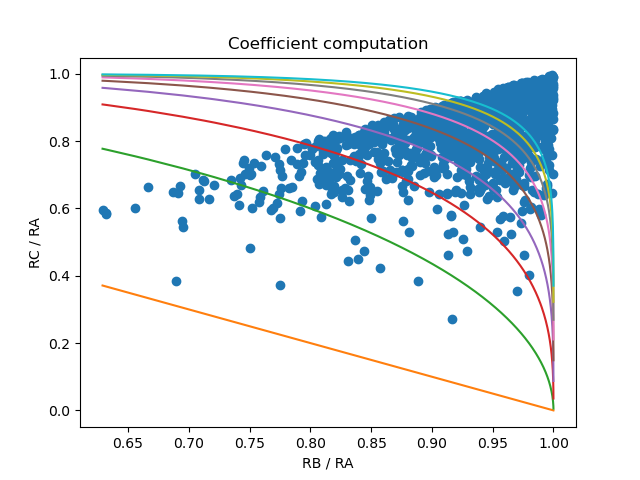

In [19]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
x = dh1/mh
y = dh2/mh
plt.plot(x,y,"o")
plt.xlabel("RB / RA")
plt.ylabel("RC / RA")
x.sort()
for i in range(1,10):
    plt.plot(x,(1-x**i)**(1/i),label=f'power {i}')
plt.title("Coefficient computation")
# plt.savefig(file_names[0]+".png",bbox_inches="tight")

Text(0, 0.5, 'Frequency')

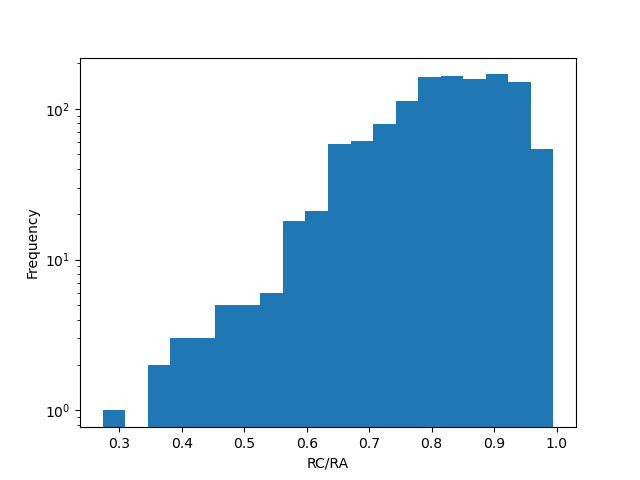

In [45]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
plt.hist(dh2/mh,bins=20,log=True)
plt.xlabel("RC/RA")
plt.ylabel("Frequency")
# plt.savefig(file_names[0]+"_hist.png",bbox_inches="tight")

Text(0, 0.5, 'Frequency')

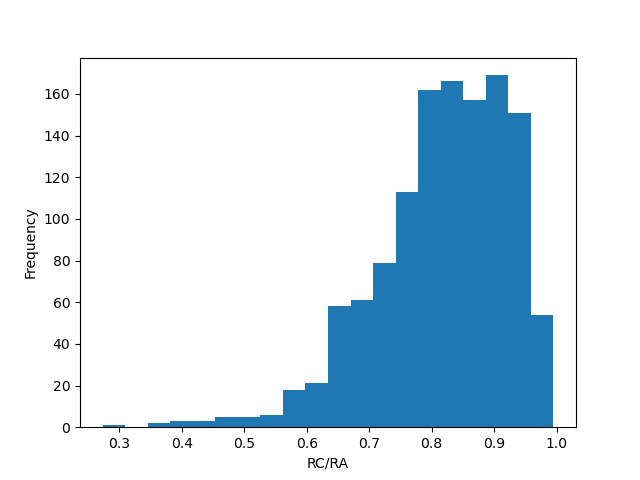

In [46]:
%matplotlib widget
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
plt.hist(dh2/mh,bins=20)
plt.xlabel("RC/RA")
plt.ylabel("Frequency")

In [101]:
ratio = dh2/mh
np.where(ratio>0.8)

(array([   0,    4,    5,    7,   10,   11,   12,   13,   15,   16,   21,
          22,   23,   24,   25,   26,   28,   32,   33,   34,   36,   37,
          39,   40,   41,   42,   43,   44,   46,   47,   48,   49,   50,
          52,   54,   55,   57,   59,   60,   61,   62,   63,   65,   67,
          68,   70,   71,   73,   75,   76,   77,   81,   82,   83,   84,
          85,   87,   88,   89,   90,   92,   94,   95,   99,  100,  101,
         103,  107,  108,  110,  112,  113,  115,  116,  117,  118,  119,
         121,  123,  124,  127,  128,  129,  130,  131,  132,  133,  134,
         135,  137,  141,  142,  145,  146,  147,  148,  149,  150,  152,
         153,  154,  155,  156,  157,  158,  159,  162,  163,  164,  165,
         166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,
         177,  178,  179,  180,  181,  184,  185,  186,  191,  192,  193,
         194,  195,  196,  197,  198,  199,  200,  201,  202,  204,  206,
         208,  209,  212,  213,  214, 

In [103]:
ratio[4]

0.8406051

In [104]:
edge_result[4]

[Edge(263358,262379), Edge(261671,262379), Edge(262379,263685)]

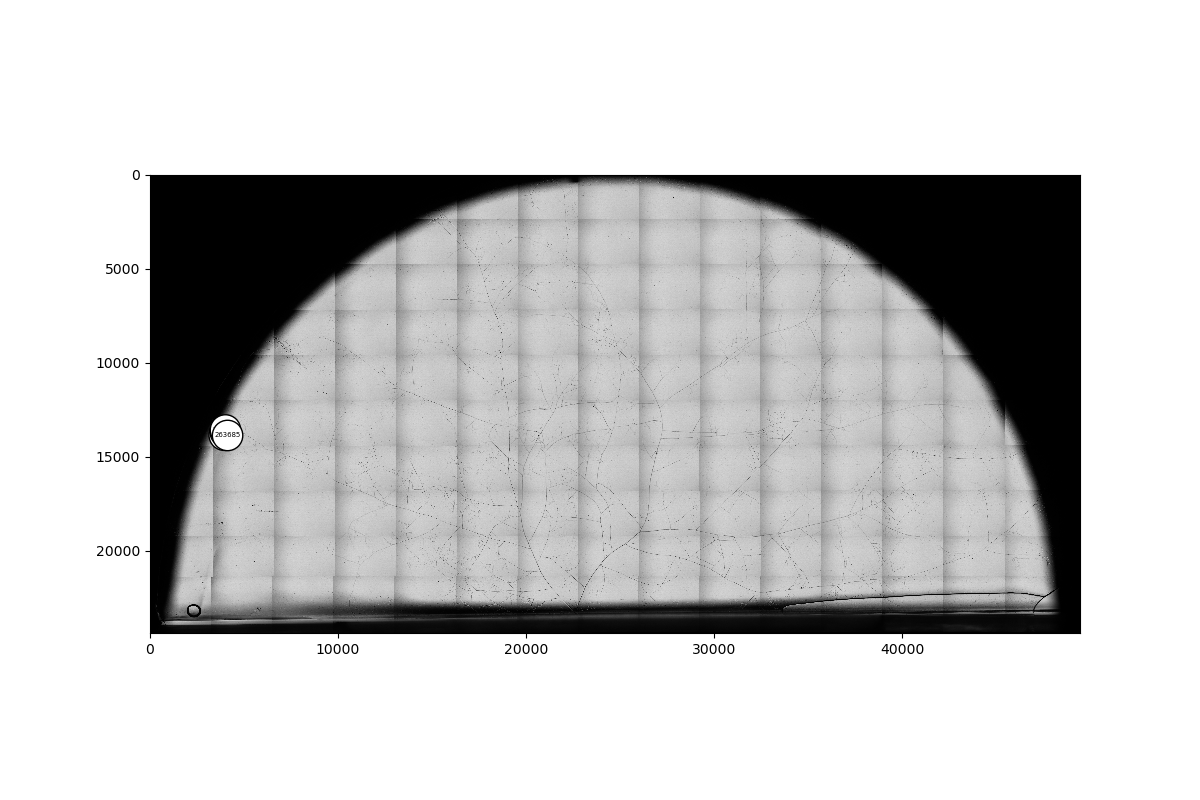

In [117]:
nodes = []
for path in [263358,262379,261671,263685]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=1,
    nodes = nodes,)

In [106]:
np.where(ratio<0.6)

(array([   2,    8,   51,   97,  109,  225,  329,  405,  413,  432,  486,
         488,  509,  572,  589,  598,  634,  641,  656,  663,  677,  687,
         721,  731,  745,  748,  783,  787,  800,  805,  891,  898,  918,
         998, 1043, 1044, 1054, 1058, 1096, 1117, 1120, 1147, 1190, 1191,
        1198]),)

In [109]:
ratio[2]

0.5742583

In [107]:
edge_result[2]

[Edge(263668,263332), Edge(263332,261671), Edge(263332,262381)]

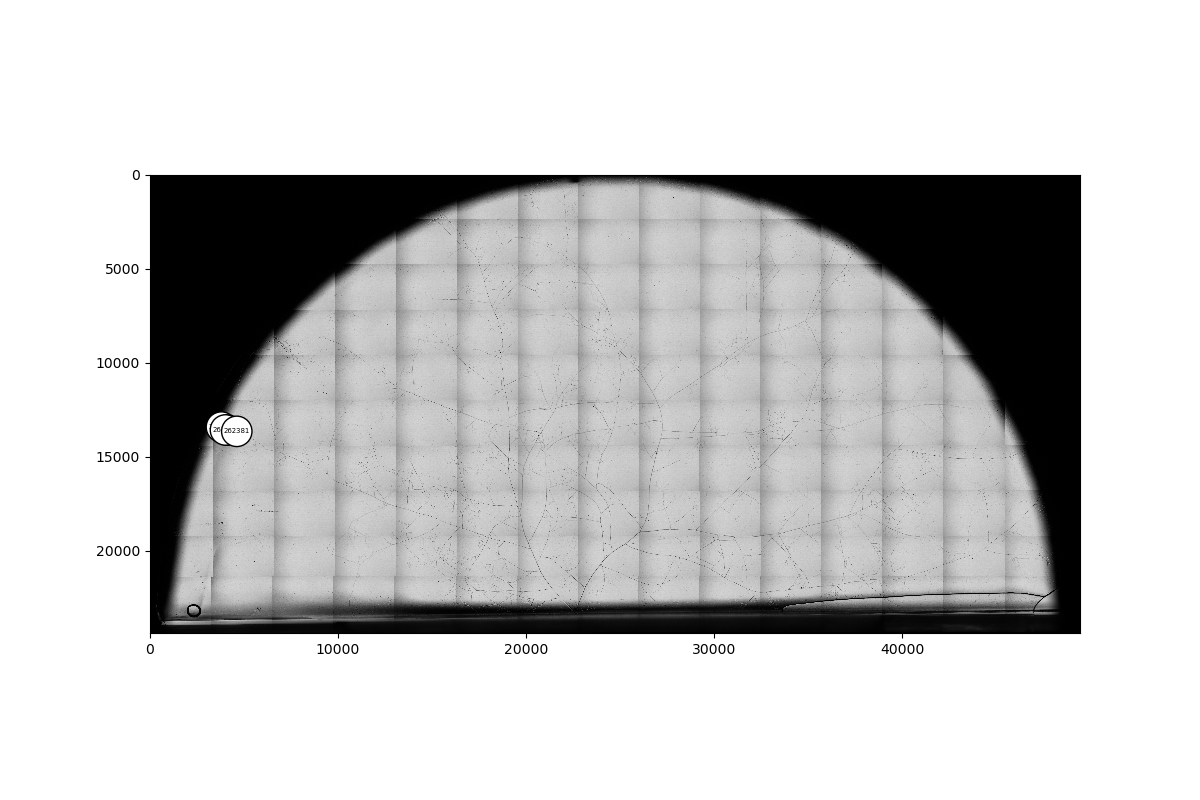

In [116]:
nodes = []
for path in [263668,263332,261671,262381]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=1,
    nodes = nodes,
    save_path = "ratio = 0.57.png"
)

In [29]:
ratio = dh2/mh
np.where(ratio>0.9)

(array([   7,   11,   13,   16,   23,   28,   36,   41,   44,   46,   47,
          48,   49,   55,   59,   63,   68,   70,   76,   87,   89,   92,
         100,  107,  108,  113,  119,  123,  130,  131,  134,  135,  137,
         148,  152,  156,  158,  162,  165,  166,  167,  168,  169,  170,
         172,  175,  176,  177,  178,  179,  180,  184,  185,  186,  196,
         199,  201,  202,  204,  206,  208,  213,  214,  215,  218,  219,
         220,  222,  223,  227,  231,  236,  238,  240,  241,  242,  244,
         247,  251,  258,  259,  260,  261,  264,  265,  270,  271,  280,
         281,  287,  295,  310,  312,  325,  326,  328,  330,  334,  335,
         337,  340,  345,  347,  348,  349,  353,  356,  360,  361,  378,
         379,  380,  383,  384,  388,  390,  394,  395,  401,  402,  409,
         420,  421,  423,  425,  428,  437,  439,  450,  456,  459,  482,
         495,  497,  524,  528,  529,  536,  537,  541,  542,  544,  545,
         553,  557,  559,  562,  570, 

In [30]:
ratio[7]

0.93347734

In [1]:
edge_result[7]

NameError: name 'edge_result' is not defined

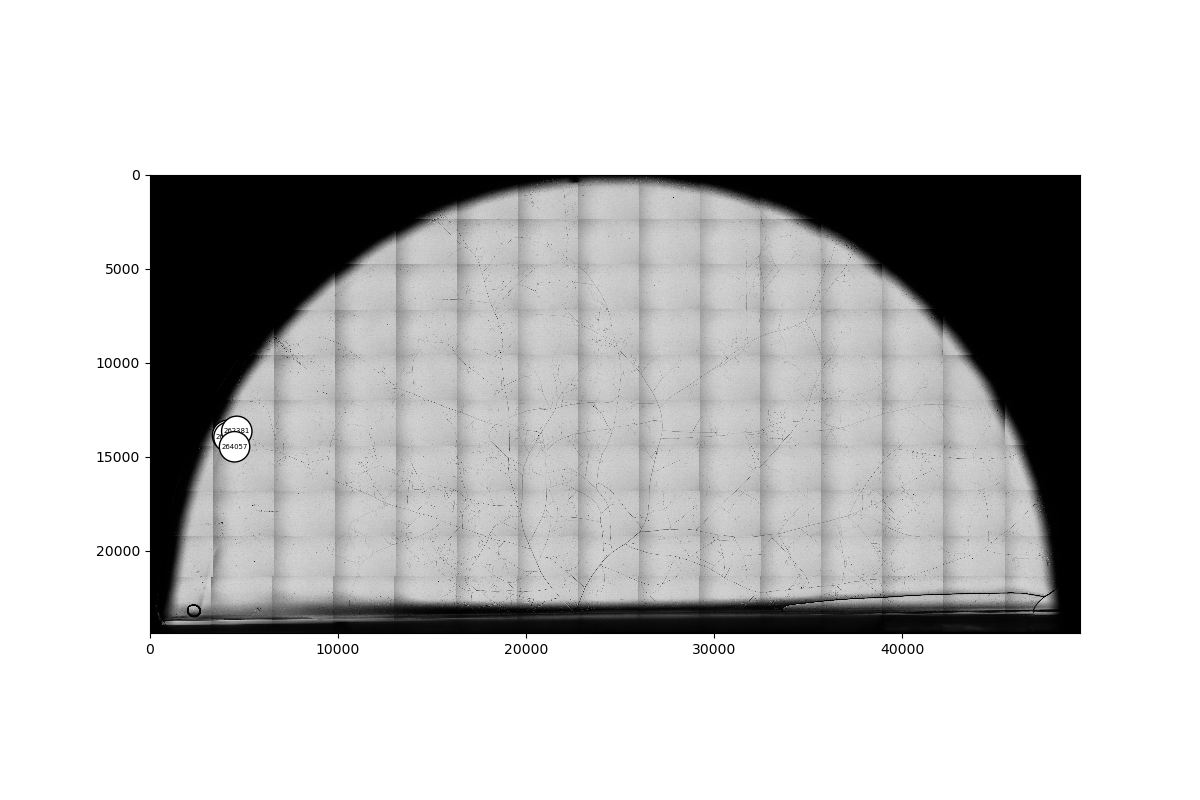

In [32]:
nodes = []
for path in [263685,264056,262381,264057]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=1,
    nodes = nodes,
)

## 20220621_0916_Plate25

In [10]:
folder = folder_df[folder_df.folder == file_names[3]]
exp = Experiment(directory)
exp.load(folder)

/Users/kai/Downloads/graduation/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2022-06-21 09:16:00


In [11]:
def load_study_zone(exp,path_code = "/Users/kai/Downloads/graduation/AMFtrack/amftrack", ):
    loc_load = os.path.join(path_code, "pipeline", "functions", "post_processing", "default_param")
    exp.center = np.load(os.path.join(loc_load, "center.npy"))
    exp.orthog = np.load(os.path.join(loc_load, "orthog.npy"))
    exp.reach_out = np.load(os.path.join(loc_load, "reach_out.npy"))
    exp.num_trunk = np.load(os.path.join(loc_load, "num_trunk.npy"))

def get_edge_node_list_by_degree(exp,t=0,degree=3,radius=1000,dist=150):
    from amftrack.pipeline.functions.image_processing.experiment_util import get_all_nodes
    from amftrack.pipeline.functions.post_processing.util import is_in_study_zone
    import networkx as nx
    load_study_zone(exp)
    node_list = get_all_nodes(exp, t)
    G, pos = exp.nx_graph[t], exp.positions[t]
    collect = []
    for i in node_list:
        if i.degree(t) == degree:
            if sum(is_in_study_zone(i,t,radius,dist)) == 2:
                collect.append(i)
    return [G.edges(int(str(i))) for i in collect], collect

def get_widths_edges_by_degree(exp,t,edge_list,width_threshold=0,degree = 3):
    width_result = []
    edge_result = []
    for edges in edge_list:
        print(edges)
        collect_width = []
        collect_edge = []
        for node1,node2 in edges:
            edge = get_edge_from_node_labels(exp,t,node1,node2)
            if edge.width(0) > width_threshold:
                collect_width.append(edge.width(0))
                collect_edge.append(edge)
        if len(collect_width) == degree:
            collect_width.sort()
            width_result.append(collect_width)
            edge_result.append(collect_edge)
    return width_result, edge_result

In [12]:
edge_list,node_list = get_edge_node_list_by_degree(exp,dist=180)

In [13]:
width_result, edge_result = get_widths_edges_by_degree(exp,0,edge_list)

[(245420, 230792), (245420, 219867), (245420, 250900)]
[(230792, 245420), (230792, 246799), (230792, 230778)]
[(219867, 245420), (219867, 250659), (219867, 250857)]
[(250900, 245420), (250900, 250857), (250900, 230778)]
[(250659, 219867), (250659, 214411), (250659, 250652)]
[(250857, 219867), (250857, 250900), (250857, 250903)]
[(250903, 250857), (250903, 250841), (250903, 226118)]
[(214411, 250659), (214411, 250627), (214411, 244054)]
[(226118, 250903), (226118, 230778), (226118, 219901)]
[(219901, 226118), (219901, 219922), (219901, 219925)]
[(214420, 246799), (214420, 251307), (214420, 246874)]
[(244054, 214411), (244054, 250683), (244054, 250641)]
[(219922, 219901), (219922, 219925), (219922, 234324)]
[(250683, 244054), (250683, 239823), (250683, 244079)]
[(163568, 251419), (163568, 246874), (163568, 246888)]
[(234324, 219922), (234324, 246752), (234324, 224541)]
[(219488, 246708), (219488, 250523), (219488, 246718)]
[(250523, 219488), (250523, 230454), (250523, 250515)]
[(224541, 

In [16]:
mh,dh1,dh2 = [],[],[]
for i in width_result:
    mh.append(i[2]/2)
    dh1.append(i[1]/2)
    dh2.append(i[0]/2)
mh = np.array(mh)
dh1 = np.array(dh1)
dh2 = np.array(dh2)

In [20]:
ratio = dh2/mh
len(ratio)

997

In [21]:
np.where(ratio>0.9)

(array([  1,   2,   4,   6,  12,  14,  17,  21,  28,  30,  31,  41,  44,
         51,  53,  54,  58,  61,  63,  65,  68,  83,  89,  98, 102, 103,
        106, 124, 127, 129, 160, 163, 166, 172, 187, 195, 197, 217, 238,
        252, 262, 268, 274, 287, 292, 293, 301, 310, 326, 327, 337, 348,
        360, 361, 372, 376, 386, 390, 394, 402, 405, 413, 415, 417, 423,
        463, 468, 481, 492, 495, 503, 506, 508, 515, 521, 522, 524, 526,
        527, 530, 531, 558, 563, 568, 579, 580, 590, 598, 602, 607, 610,
        620, 621, 625, 636, 640, 641, 653, 659, 673, 680, 684, 688, 689,
        694, 700, 702, 737, 738, 746, 768, 774, 776, 780, 794, 801, 855,
        859, 868, 875, 915, 921, 926, 930, 937, 941, 978, 991]),)

In [29]:
ratio[506]

0.9494222519551608

In [22]:
edge_result[506]

[Edge(249671,249691), Edge(249691,249697), Edge(249691,249660)]

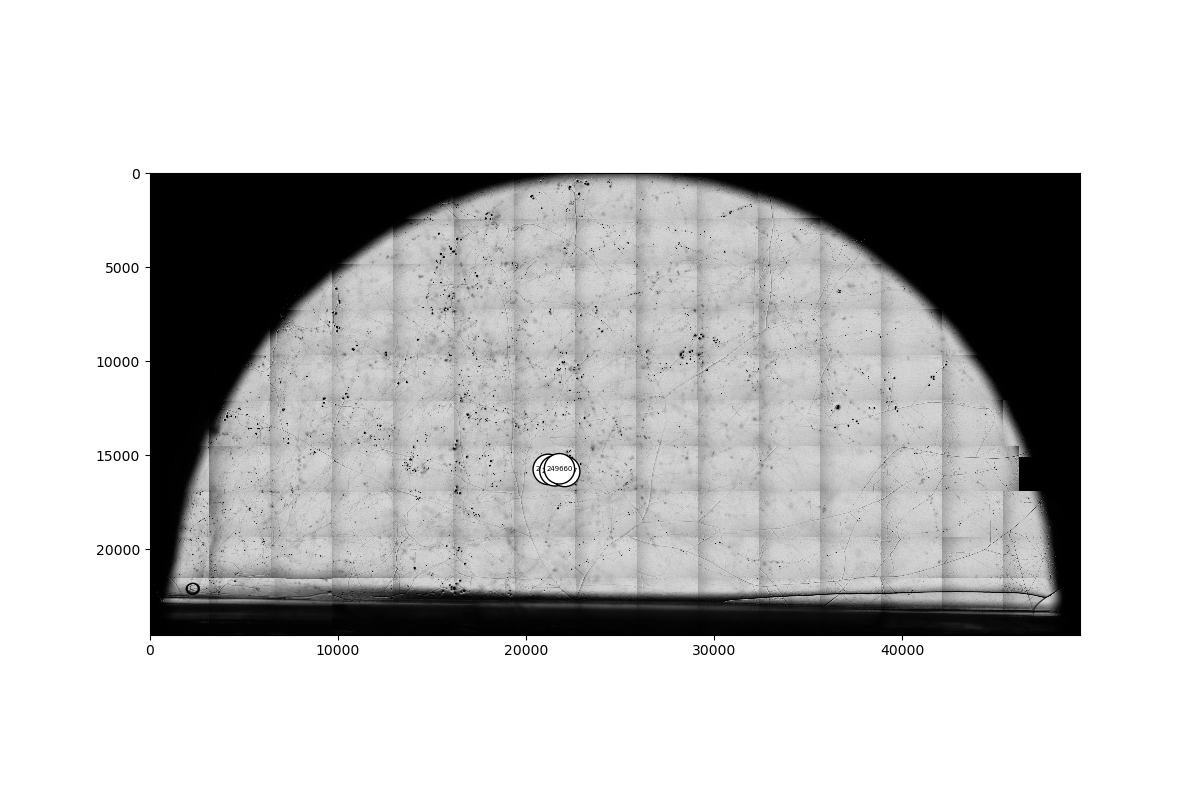

In [23]:
# higher than 0.9
nodes=[]
for path in [249671,249691,249697,249660]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=1,
    nodes = nodes,
)

In [25]:
np.where(ratio<0.6)

(array([  8,  20,  73,  77,  78,  81,  84,  85,  86,  99, 108, 110, 116,
        121, 128, 130, 134, 135, 136, 137, 138, 139, 140, 145, 148, 150,
        152, 154, 155, 156, 157, 159, 164, 179, 180, 182, 188, 192, 208,
        211, 213, 222, 224, 227, 228, 231, 235, 239, 240, 241, 244, 246,
        254, 256, 260, 265, 266, 273, 282, 283, 284, 286, 289, 295, 296,
        305, 312, 316, 319, 321, 329, 332, 334, 336, 339, 341, 343, 344,
        345, 352, 353, 354, 355, 357, 359, 375, 383, 393, 406, 407, 412,
        428, 429, 432, 437, 441, 448, 449, 450, 454, 456, 457, 461, 462,
        464, 467, 471, 473, 479, 483, 488, 496, 497, 500, 501, 504, 518,
        529, 533, 534, 538, 541, 542, 543, 544, 547, 550, 556, 560, 561,
        562, 567, 569, 573, 578, 583, 589, 592, 595, 609, 616, 619, 623,
        626, 630, 633, 638, 643, 650, 651, 652, 656, 657, 660, 663, 665,
        666, 672, 674, 676, 677, 678, 681, 697, 717, 727, 732, 733, 736,
        740, 741, 744, 749, 753, 757, 762, 767, 772

In [28]:
ratio[573]

0.5362665376033332

In [32]:
dh2[573]

1.8750922679901123

In [27]:
edge_result[573]

[Edge(218085,202197), Edge(202197,218146), Edge(202197,249310)]

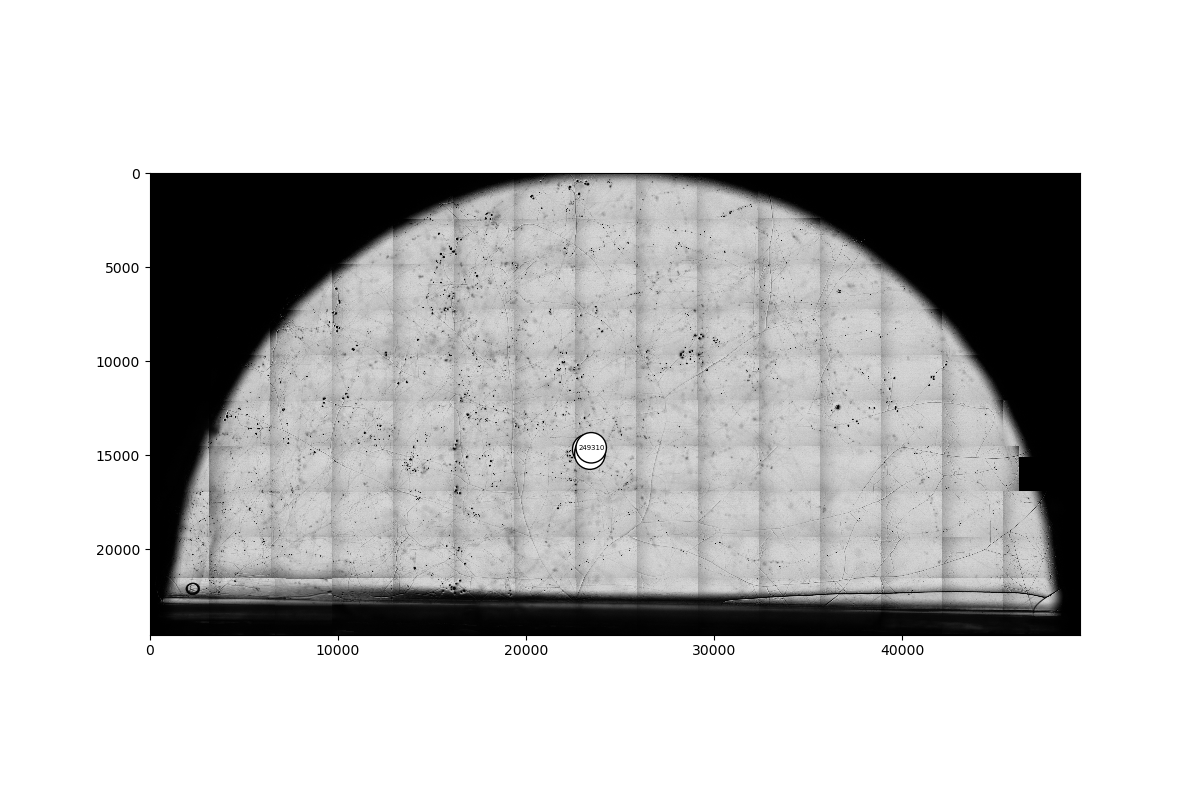

In [30]:
# lower than 0.6
nodes = []
for path in [218085,202197,218146,249310]:
    nodes.append(Node(path,exp))
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=1,
    nodes = nodes,
)